In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas as pd
import os, glob
import numpy as np
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataset.kernel_image_pair import KernelImagePair, default_augmentations, default_transforms
from network.sftmd import SFTMD, Predictor, Corrector

In [2]:
import numpy as np
import math
from torchvision.utils import make_grid
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [294]:
train_imgs = glob.glob("../data/DIV2K/DIV2K_train_HR/**/*.png", recursive=True)
test_imgs = glob.glob("../data/DIV2K/DIV2K_valid_HR/**/*.png", recursive=True)
scale=4
ker_dim=21
aniso=True
diverse=True

# ker_dim=10
# aniso=False
# diverse=False
train_kernel = f"kernels/train/kernel_scale{scale}_{'aniso' if aniso else 'iso'}_dim{ker_dim}{'_diverse' if diverse else ''}.pth"
test_kernel = f"kernels/test_2/kernel_scale{scale}_{'aniso' if aniso else 'iso'}_dim{ker_dim}{'_diverse' if diverse else ''}.pth"


testsets = dict(
    set5=glob.glob("../data/testing_datasets/Set5/*.png", recursive=True),
    div2k=glob.glob("../data/DIV2K/DIV2K_valid_HR/*.png", recursive=True),
#     set14=glob.glob("../data/testing_datasets/Set14/*.png", recursive=True),
    set14=glob.glob("../data/set14/Set14/images/*.png", recursive=True),
    urban100=glob.glob("../data/testing_datasets/Urban100/*.png", recursive=True),
    ffhq=glob.glob("../../ffhq-dataset/data/images1024x1024_test/69000/*.png", recursive=True)
)
batch_size=1

In [295]:
dataset = KernelImagePair(imgs=testsets['set5'], 
                            kernel_pickle=test_kernel, scale=scale, 
                            augmentations=default_augmentations, transforms=default_transforms, 
#                           augmentations=augmentations, transforms=default_transforms, 
                            seed=0, train=False, cubic=True, downsample_on_pipe=False, interpolation="nearest")
dl = DataLoader(dataset)
def image_to_bd(img, cuda=True):
    # img : tensor(CHW), np.array(HWC) 
    dataset.imgs = [img]
    ds = next(iter(dl))
    if cuda:
        with torch.no_grad():
            for k, v in ds.items():
                ds[k] = ds[k].cuda()
    return ds

In [300]:
# Face Images
# _p = "demo_face/ckpt/predictor/191101_x4_multi_bs16_nf128_noise_cubic_patch256_radam.pth"
# _c = "demo_face/ckpt/corrector/191028_x4_cosine_bs16_nf128_noise_cubic_patch256_2__191101_radam.pth-11000"
# _s = "demo_face/ckpt/sftmd/191028_x4_cosine_bs16_nf128_noise_cubic_patch256_2.pth"

# _p = "demo_face/ckpt/predictor/191108_x4_multi_bs16_cubic_patch256_radam.pth-55500"
# _c = "demo_face/ckpt/corrector/191028_x4_cosine_bs16_nf128_cubic_patch256_2__191108_radam_55500_2.pth-3600"
# _s = "demo_face/ckpt/sftmd/191028_x4_cosine_bs16_nf128_noise_cubic_patch256_2.pth"
# nf = 128


# # # Normal Images
# # _p = "ckpt/predictor/191022_0_x4_lr_1e-4_bs16_patch256.pth"
# # _p = "ckpt/predictor/191105_0_x4_lr_1e-4_bs16_patch256.pth"
# # _p = "ckpt/predictor/191105_0_x4_lr_1e-4_bs16_patch256.pth-2000"
# _p = "ckpt/predictor/191106_0_x4_lr_1e-4_bs16_patch256_radam_norecon.pth-59000"
# # _p = "demo_face/ckpt/predictor/191101_x4_multi_bs16_nf128_noise_cubic_patch256_radam.pth"
# # _p = "ckpt/predictor/191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16.pth"
# # _c = "ckpt/corrector/191022_0_x4___191022_0_x4_191026.pth-27000"
# # _c = "ckpt/corrector/191022_0_x4___191105_0_x4_191105.pth-1000"
# _c = "ckpt/corrector/191022_0_x4___191106_0_x4_norecon_191106_radam_delta.pth"
# _s = "ckpt/sftmd/191022_0_x4_mutli_lr_1e-4_bs16.pth"
# ker_dim=10

# 191110 setttings

# _p = "ckpt/predictor/191110_0_x4_lr_1e-4_bs16_patch256_radam_norecon.pth-17000"
# _c = "ckpt/corrector/191022_0_x4___191110_0_x4_norecon_191110_radam_delta.pth-12000"
# _s = "ckpt/sftmd/191022_0_x4_mutli_lr_1e-4_bs16.pth"

# 191113 settings
# _p = "demo_face/predictor/191113_x4_mutli_144_bs16_radam_ker21_jpegaug.pth"
# _s = "demo_face/sftmd/191113_x4_mutli_144_bs16_radam_ker21_jpegaug.pth"
# _c = "demo_face/corrector/191113_pair.pth-17400"

# # 191119 settings
# _p = "ckpt/predictor/191119_x4_mutli_144_bs16_radam_ker21_aniso.pth"
# _s = "ckpt/sftmd/191119_x4_mutli_144_bs16_radam_ker21_aniso.pth"
# _c = "ckpt/corrector/191119_x4_multi_aniso_pair.pth"
# ker_dim = 21

# # 191209 settings
# _p = "ckpt/predictor/191209_x4_mutli_144_bs16_radam_ker21_aniso.pth"
# _s = "ckpt/sftmd/191209_x4_mutli_144_bs16_radam_ker21_aniso.pth"
# _c = "ckpt/corrector/191209_x4_multi_aniso_pair-161000.pth-27600"
# ker_dim = 21

# 191211 settings
_p = "ckpt/predictor/191211_x4_mutli_144_bs16_radam_ker21_aniso.pth-27000"
_s = "ckpt/sftmd/191209_x4_mutli_144_bs16_radam_ker21_aniso.pth"
_c = "ckpt/corrector/191209_x4_multi_aniso_191211_predictor-27000.pth-99900"
ker_dim = 21


nf = 64
num_iter = 40


In [301]:
predictor = Predictor(dataset.pca, code_len=ker_dim).cuda()
corrector = Corrector(nf=nf, code_len = ker_dim).cuda()
sftmd = SFTMD(scale=scale, nf=nf, input_para=ker_dim).cuda()

In [302]:
def setting(net, ckpt):
    net.load_state_dict(torch.load(ckpt))
    net.eval()

In [303]:
ll = [(sftmd, _s), (predictor, _p), (corrector, _c)]
[setting(*l) for l in ll]

[None, None, None]

In [87]:
def guess_bd(bd):
    bd['k_reduced_gt'] = bd['k_reduced']
    with torch.no_grad():
        bd['k_reduced'] = predictor(bd, recon_kernel=False)
    initial_guess = bd['k_reduced'][0].cpu()
    
    w, h = bd['HR'].shape[2:]
    
    with torch.no_grad():
        srs = []
        krs = []
        
        for i in range(num_iter):
            sr = sftmd(bd)
            bd['SR'] = sr
            bd['k_reduced'] = corrector(bd)
            srs.append(sr[0].cpu())
            krs.append(bd['k_reduced'][0].cpu())
        hr = bd['HR'][0].cpu()
    
    return dict(
                k_reduced_gt=bd['k_reduced_gt'][0].cpu(),
                lr=bd['LR'][0].cpu(),
                lr_cubic = bd['lr_cubic'][0].cpu(),
                srs=srs,
                krs=krs,
                initial_guess=initial_guess,
                hr=hr,
               )
def psnr(est, gt, is_rgb=True):
    diff = est - gt
    shave = scale
    if diff.size(1) > 1 and not is_rgb:
        gray_coeffs = [65.738, 129.057, 25.064]
        convert = diff.new_tensor(gray_coeffs).view(1, 3, 1, 1) / 256
        diff = diff.mul(convert).sum(dim=1)
    valid = diff[..., shave:-shave, shave:-shave]
    mse = valid.pow(2).mean()
    # 20 * torch.log10(1/(diff))
    return -10 * torch.log10(mse)

In [88]:
def inference_reals(imgs, is_rgb=False):
    df_dict = dict(cubic=[])
    results_list = []
    for i in range(num_iter):
        df_dict["iter_"+str(i+1)] = []

    dataset.random = np.random.RandomState(0)
    for img in tqdm(imgs):
        bd = image_to_bd(img)
        results = guess_bd(bd)
        results_list.append(results)
        df_dict['cubic'].append(psnr(results['lr_cubic'], results['hr'], is_rgb).item())

        for i, sr in enumerate(results['srs']):
            df_dict["iter_"+str(i+1)].append(psnr(sr, results['hr'], is_rgb).item())

    df = pd.DataFrame(df_dict)
    display(df)
    print(df.mean())
    return df, results_list

In [291]:
# my IKC (iso)
set5 = glob.glob("test_imgs/set5/aniso_diverse/lr/*.png")
df, results_list = inference_reals(set5)

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


cubic     iter_1     iter_2     iter_3     iter_4     iter_5  \
0  18.925062  22.068327  22.440565  22.884447  23.340145  23.784893   
1  29.415745  27.655107  27.833637  28.014738  28.192917  28.366737   
2  23.310947  26.914997  27.102182  27.275223  27.431618  27.571795   
3  31.009445  32.530170  32.494331  32.477699  32.467587  32.459991   
4  28.334391  32.776485  32.806465  32.852386  32.902809  32.953438   

      iter_6     iter_7     iter_8     iter_9  ...    iter_31    iter_32  \
0  24.209154  24.608080  24.978870  25.318390  ...  26.110304  26.006165   
1  28.535053  28.697947  28.855366  29.006809  ...  31.167383  31.218773   
2  27.695717  27.803633  27.896889  27.975618  ...  27.898464  27.863041   
3  32.453743  32.448486  32.443962  32.440060  ...  32.390999  32.388500   
4  33.002007  33.048141  33.091393  33.131966  ...  33.529022  33.529594   

     iter_33    iter_34    iter_35    iter_36    iter_37    iter_38  \
0  25.902397  25.800117  25.699459  25.601040  25.504787  25.411089   
1  31.266821  31.311533  31.353159  31.392080  31.428169  31.461637   
2  27.827093  27.790854  27.754162  27.717346  27.680405  27.643406   
3  32.385857  32.383083  32.380177  32.377171  32.374027  32.370651   
4  33.528858  33.526901  33.523853  33.519821  33.514416  33.507744   

     iter_39    iter_40  
0  25.319717  25.230886  
1  31.492573  31.520807  
2  27.606298  27.569220  
3  32.367115  32.363441  
4  33.499809  33.491074  

[5 rows x 41 columns]

cubic      26.199118
iter_1     28.389017
iter_2     28.535436
iter_3     28.700899
iter_4     28.867015
iter_5     29.027371
iter_6     29.179135
iter_7     29.321257
iter_8     29.453296
iter_9     29.574569
iter_10    29.685443
iter_11    29.786004
iter_12    29.876288
iter_13    29.956591
iter_14    30.027219
iter_15    30.088984
iter_16    30.141844
iter_17    30.185563
iter_18    30.221007
iter_19    30.248946
iter_20    30.270039
iter_21    30.285044
iter_22    30.294512
iter_23    30.298917
iter_24    30.298866
iter_25    30.294914
iter_26    30.287636
iter_27    30.277696
iter_28    30.265570
iter_29    30.251638
iter_30    30.236104
iter_31    30.219234
iter_32    30.201215
iter_33    30.182205
iter_34    30.162498
iter_35    30.142162
iter_36    30.121492
iter_37    30.100361
iter_38    30.078905
iter_39    30.057103
iter_40    30.035086
dtype: float64


In [304]:
set5 = glob.glob("test_imgs/set5/aniso_diverse/lr/*.png")
df, results_list = inference_reals(set5)

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


cubic     iter_1     iter_2     iter_3     iter_4     iter_5  \
0  18.925062  24.359165  22.450388  24.985767  25.829311  25.729788   
1  29.415745  31.845228  32.323032  30.722038  31.438313  31.558460   
2  23.310947  27.977476  28.169306  25.457228  26.707632  27.762325   
3  31.009445  32.655735  32.691006  32.670483  32.729748  32.747864   
4  28.334391  32.121014  33.353432  33.618401  33.517338  33.538013   

      iter_6     iter_7     iter_8     iter_9  ...    iter_31    iter_32  \
0  25.517866  25.984619  25.971096  25.687359  ...  24.397160  24.332211   
1  31.867481  31.826403  31.882782  31.908674  ...  32.206966  32.211464   
2  27.110352  26.887272  27.624641  27.323463  ...  27.199993  27.179768   
3  32.748196  32.745964  32.746861  32.747124  ...  32.758812  32.759903   
4  33.599159  33.607460  33.597271  33.604439  ...  33.675251  33.675797   

     iter_33    iter_34    iter_35    iter_36    iter_37    iter_38  \
0  24.267273  24.202993  24.139034  24.071482  24.002636  23.935568   
1  32.215702  32.219715  32.223568  32.227280  32.230881  32.234379   
2  27.174921  27.175827  27.161047  27.152500  27.151947  27.141523   
3  32.760990  32.761925  32.762680  32.763172  32.763504  32.763641   
4  33.676105  33.676201  33.676147  33.675972  33.675694  33.675247   

     iter_39    iter_40  
0  23.869144  23.803928  
1  32.237797  32.241158  
2  27.132145  27.129639  
3  32.763584  32.763355  
4  33.674667  33.673969  

[5 rows x 41 columns]

cubic      26.199118
iter_1     29.791724
iter_2     29.797433
iter_3     29.490783
iter_4     30.044468
iter_5     30.267290
iter_6     30.168611
iter_7     30.210344
iter_8     30.364530
iter_9     30.254212
iter_10    30.230100
iter_11    30.288802
iter_12    30.266922
iter_13    30.227780
iter_14    30.250319
iter_15    30.248106
iter_16    30.209929
iter_17    30.213186
iter_18    30.215121
iter_19    30.186822
iter_20    30.176925
iter_21    30.177246
iter_22    30.157792
iter_23    30.142340
iter_24    30.138323
iter_25    30.124372
iter_26    30.107595
iter_27    30.099032
iter_28    30.086724
iter_29    30.070121
iter_30    30.059194
iter_31    30.047636
iter_32    30.031828
iter_33    30.018998
iter_34    30.007332
iter_35    29.992495
iter_36    29.978081
iter_37    29.964932
iter_38    29.950072
iter_39    29.935468
iter_40    29.922410
dtype: float64


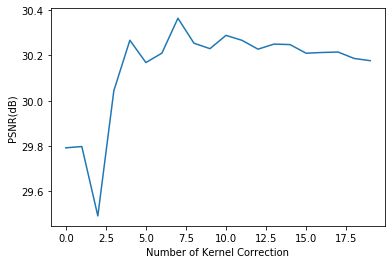

In [305]:
plt.xlabel("Number of Kernel Correction")
plt.ylabel("PSNR(dB)")
plt.plot(range(20), df.mean()[1:21])

In [196]:
def save_bicubic(set5):
    for i, img in enumerate(set5):
        save_path = img.replace("/lr/", f"/sr_bicubic/")
        print(save_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        lr = cv2.imread(img)
        sr = cv2.resize(lr, (lr.shape[1]*scale, lr.shape[0]*scale), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(save_path, sr)

In [197]:
save_bicubic(set5)

test_imgs/set5/aniso_diverse/sr_bicubic/butterfly.png
test_imgs/set5/aniso_diverse/sr_bicubic/baby.png
test_imgs/set5/aniso_diverse/sr_bicubic/woman.png
test_imgs/set5/aniso_diverse/sr_bicubic/head.png
test_imgs/set5/aniso_diverse/sr_bicubic/bird.png


In [292]:
def save_result_list(set5, save_iters = [0, 6, 39]):
    for i, img in enumerate(set5):
        for save_iter in save_iters:
            save_path = img.replace("/lr/", f"/sr_iso_{save_iter}/")
            print(save_path)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            sr = Image.fromarray(tensor2img(results_list[i]['srs'][save_iter]))
            sr.save(save_path)

In [293]:
save_result_list(set5)

test_imgs/set5/aniso_diverse/sr_iso_0/butterfly.png
test_imgs/set5/aniso_diverse/sr_iso_6/butterfly.png
test_imgs/set5/aniso_diverse/sr_iso_39/butterfly.png
test_imgs/set5/aniso_diverse/sr_iso_0/baby.png
test_imgs/set5/aniso_diverse/sr_iso_6/baby.png
test_imgs/set5/aniso_diverse/sr_iso_39/baby.png
test_imgs/set5/aniso_diverse/sr_iso_0/woman.png
test_imgs/set5/aniso_diverse/sr_iso_6/woman.png
test_imgs/set5/aniso_diverse/sr_iso_39/woman.png
test_imgs/set5/aniso_diverse/sr_iso_0/head.png
test_imgs/set5/aniso_diverse/sr_iso_6/head.png
test_imgs/set5/aniso_diverse/sr_iso_39/head.png
test_imgs/set5/aniso_diverse/sr_iso_0/bird.png
test_imgs/set5/aniso_diverse/sr_iso_6/bird.png
test_imgs/set5/aniso_diverse/sr_iso_39/bird.png


In [239]:
set5 = glob.glob("test_imgs/set5/aniso/lr/*.png")
df, results_list = inference_reals(set5)

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


cubic     iter_1     iter_2     iter_3     iter_4     iter_5  \
0  21.554605  24.498333  24.531139  24.873508  24.895056  24.926414   
1  30.656868  33.440010  33.176205  33.059795  33.164806  33.195480   
2  24.934904  29.879759  30.120012  29.803421  29.744938  29.735271   
3  31.128338  32.676453  32.969238  32.991463  33.081421  33.087151   
4  29.635601  32.059902  32.023312  32.433060  32.433235  32.303738   

      iter_6     iter_7     iter_8     iter_9  ...    iter_31    iter_32  \
0  24.919186  24.923838  24.922558  24.922009  ...  24.668072  24.647512   
1  33.230415  33.255791  33.277439  33.293678  ...  33.474297  33.477318   
2  30.012684  29.998312  29.890987  29.894939  ...  29.734785  29.725964   
3  33.086353  33.083374  33.082932  33.081123  ...  33.060921  33.060127   
4  32.351986  32.413967  32.441360  32.460396  ...  32.804272  32.810760   

     iter_33    iter_34    iter_35    iter_36    iter_37    iter_38  \
0  24.626472  24.605316  24.583702  24.561508  24.538879  24.515919   
1  33.480095  33.482639  33.484951  33.487030  33.488972  33.490776   
2  29.717043  29.708363  29.699772  29.691071  29.682598  29.674355   
3  33.059341  33.058517  33.057705  33.056881  33.056080  33.055290   
4  32.816654  32.822376  32.828110  32.833420  32.838463  32.843136   

     iter_39    iter_40  
0  24.492472  24.468769  
1  33.492428  33.493885  
2  29.666212  29.658260  
3  33.054520  33.053616  
4  32.847366  32.851227  

[5 rows x 41 columns]

cubic      27.582063
iter_1     30.510891
iter_2     30.563981
iter_3     30.632249
iter_4     30.663891
iter_5     30.649611
iter_6     30.720125
iter_7     30.735056
iter_8     30.723055
iter_9     30.730429
iter_10    30.746435
iter_11    30.750482
iter_12    30.751584
iter_13    30.756612
iter_14    30.761702
iter_15    30.764186
iter_16    30.765994
iter_17    30.768087
iter_18    30.769768
iter_19    30.770604
iter_20    30.771047
iter_21    30.771257
iter_22    30.770776
iter_23    30.769672
iter_24    30.768215
iter_25    30.766401
iter_26    30.764148
iter_27    30.761597
iter_28    30.758788
iter_29    30.755675
iter_30    30.752225
iter_31    30.748469
iter_32    30.744336
iter_33    30.739921
iter_34    30.735442
iter_35    30.730848
iter_36    30.725982
iter_37    30.720998
iter_38    30.715895
iter_39    30.710600
iter_40    30.705151
dtype: float64


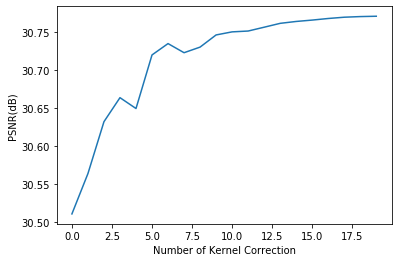

In [240]:
plt.xlabel("Number of Kernel Correction")
plt.ylabel("PSNR(dB)")
plt.plot(range(20), df.mean()[1:21])

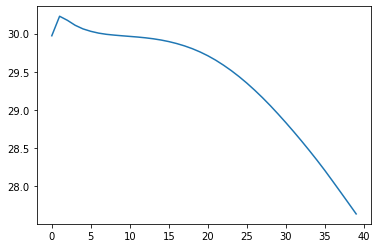

In [24]:
plt.plot(range(40), pd.read_csv("set5_aniso_train.csv").mean()[1:])

In [278]:
mean_ = predictor.mean_.cpu()
components_ = predictor.components_.cpu()
def get_recon(flat):
    batch_mean = mean_.expand(flat.shape[0], 441)
    recon = torch.matmul(flat, components_) + batch_mean
    return recon

test_imgs/set5/aniso_diverse/lr/woman.png


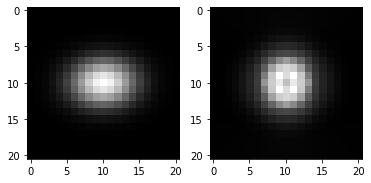

In [316]:
i =  2
r = results_list[i]
print(set5[i])
gt = torch.load(set5[i].replace("lr", "k")).numpy()
recon = get_recon(r['krs'][6].unsqueeze(0)).reshape((21,21))
plt.subplot(121)
plt.imshow(gt, cmap="gray")
plt.subplot(122)
plt.imshow(recon, cmap="gray")

In [33]:
sr =  '/home/choijongho/workspace/sang/ikc_synthetic/butterfly.png'
hr = '/home/choijongho/synthetic_lrs/original/butterfly.png'
def psnr_img_path(sr, hr):
    sr = imageio.imread(sr)
    sr = sr.transpose((2, 0, 1))
    sr = torch.from_numpy(sr).unsqueeze(0).float() / 255
    hr = imageio.imread(hr)
    hr = hr.transpose((2, 0, 1))
    hr = torch.from_numpy(hr).unsqueeze(0).float() / 255
    return psnr(sr, hr, is_rgb=False).item()

In [160]:
def image_to_LR(img):
#     dataset.random = np.random.RandomState(0)
    bd = image_to_bd(img)
    lr = Image.fromarray(tensor2img(bd['LR']))
    return lr

In [159]:
def save_dataset(imgs, destination="test_imgs/"):
    os.makedirs(destination + "/lr/", exist_ok=True)
    os.makedirs(destination + "/hr/", exist_ok=True)
    dataset.random = np.random.RandomState(0)
    for img in imgs:
        pil = image_to_LR(img)
        pil.save(os.path.join(destination + "/lr/", os.path.basename(img)))
        pil = Image.open(img)
        pil.save(os.path.join(destination + "/hr/", os.path.basename(img)))

In [73]:
save_dataset(testsets['urban100'], "test_imgs/urban100/aniso/")

In [199]:
srs = sorted(glob.glob("test_imgs/set5/aniso_diverse/sr_edsr/*.png"))
hrs = sorted(glob.glob("test_imgs/set5/aniso_diverse/hr/*.png"))
import imageio
psnrs = []
for i in range(5):
    sr = imageio.imread(srs[i])
    sr = sr.transpose((2, 0, 1))
    sr = torch.from_numpy(sr).unsqueeze(0).float() / 255
    hr = imageio.imread(hrs[i])
    hr = hr.transpose((2, 0, 1))
    hr = torch.from_numpy(hr).unsqueeze(0).float() / 255
    psnrs.append(psnr(sr, hr, is_rgb=False))
    
print(sum(psnrs) / 5)
print(psnrs)
print(srs)

tensor(28.0552)
[tensor(31.0897), tensor(32.5011), tensor(19.9151), tensor(32.2697), tensor(24.5005)]
['test_imgs/set5/aniso_diverse/sr_edsr/baby_x4_SR.png', 'test_imgs/set5/aniso_diverse/sr_edsr/bird_x4_SR.png', 'test_imgs/set5/aniso_diverse/sr_edsr/butterfly_x4_SR.png', 'test_imgs/set5/aniso_diverse/sr_edsr/head_x4_SR.png', 'test_imgs/set5/aniso_diverse/sr_edsr/woman_x4_SR.png']


In [284]:
srs = sorted(glob.glob("test_imgs/set5/aniso_diverse/sr_edsr/*.png"))
hrs = sorted(glob.glob("test_imgs/set5/aniso/hr/*.png"))
import imageio
psnrs = []
for i in range(5):
    sr = imageio.imread(srs[i])
    sr = sr.transpose((2, 0, 1))
    sr = torch.from_numpy(sr).unsqueeze(0).float() / 255
    hr = imageio.imread(hrs[i])
    hr = hr.transpose((2, 0, 1))
    hr = torch.from_numpy(hr).unsqueeze(0).float() / 255
    psnrs.append(psnr(sr, hr, is_rgb=False))
    
print(sum(psnrs) / 5)
print(psnrs)

tensor(28.0552)
[tensor(31.0897), tensor(32.5011), tensor(19.9151), tensor(32.2697), tensor(24.5005)]


In [57]:
mean_ = predictor.mean_.cpu()
components_ = predictor.components_.cpu()
def get_recon(flat):
    batch_mean = mean_.expand(flat.shape[0], 441)
    recon = torch.matmul(flat, components_) + batch_mean
    return recon

In [32]:
i = 2
k = results_list[i]['initial_guess']
# recon = predictor.get_recon(k.unsqueeze(0).cuda()).cpu()
# recon_gt = predictor.get_recon(results_list[i]['k_reduced_gt'].unsqueeze(0).cuda()).cpu()
recon = get_recon(k.unsqueeze(0))
recon_gt = get_recon(results_list[i]['k_reduced_gt'].unsqueeze(0))
recon.max(), recon_gt.max(), recon.sum()

(tensor(0.1880), tensor(0.0701), tensor(1.))

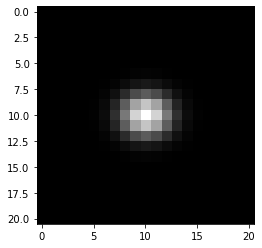

In [33]:
plt.imshow(recon_gt.view(21,21).numpy(), cmap="gray")

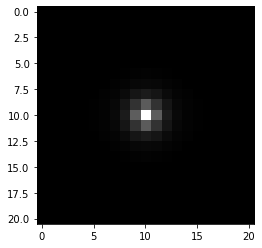

In [34]:
plt.imshow(recon.view(21, 21).numpy(), cmap="gray")

0 tensor(0.0535) tensor(0.0074) tensor(1.0000)


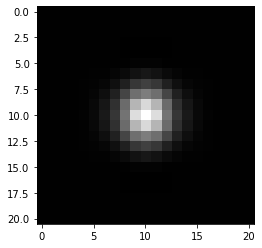

1 tensor(0.0516) tensor(0.0074) tensor(1.0000)


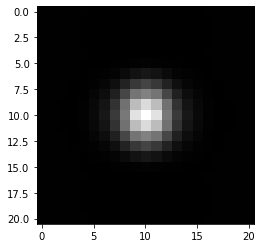

2 tensor(0.0497) tensor(0.0073) tensor(1.0000)


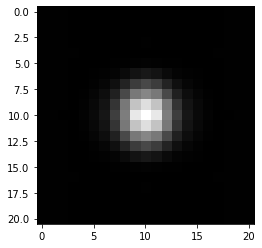

3 tensor(0.0478) tensor(0.0073) tensor(1.)


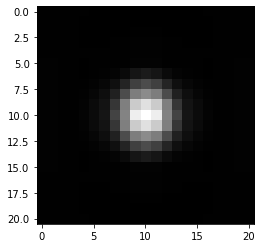

4 tensor(0.0461) tensor(0.0072) tensor(1.0000)


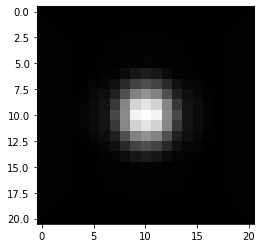

5 tensor(0.0444) tensor(0.0072) tensor(1.0000)


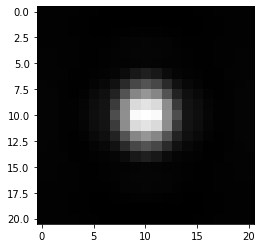

6 tensor(0.0429) tensor(0.0071) tensor(1.)


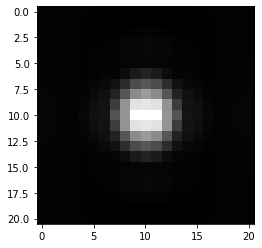

7 tensor(0.0423) tensor(0.0071) tensor(1.0000)


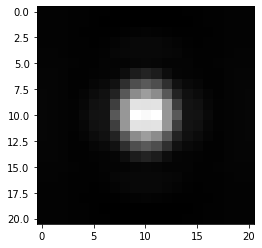

8 tensor(0.0417) tensor(0.0070) tensor(1.0000)


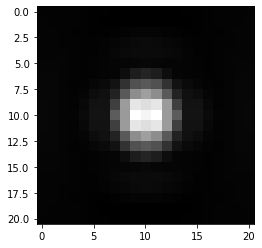

9 tensor(0.0411) tensor(0.0069) tensor(1.0000)


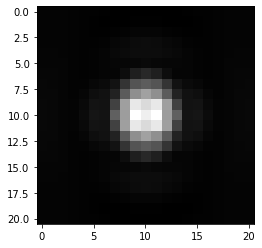

10 tensor(0.0405) tensor(0.0069) tensor(1.0000)


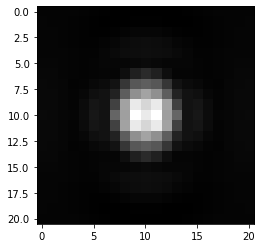

11 tensor(0.0399) tensor(0.0068) tensor(1.0000)


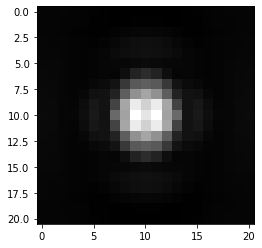

12 tensor(0.0394) tensor(0.0068) tensor(1.)


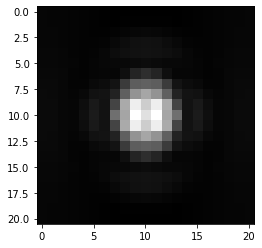

13 tensor(0.0388) tensor(0.0067) tensor(1.0000)


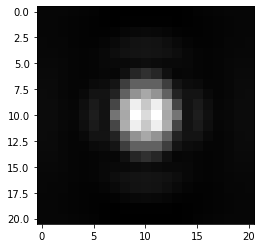

14 tensor(0.0382) tensor(0.0067) tensor(1.0000)


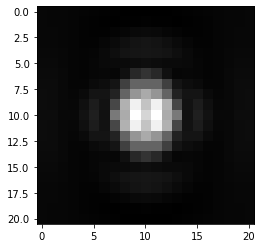

15 tensor(0.0376) tensor(0.0066) tensor(1.0000)


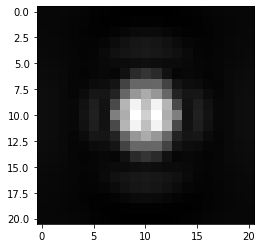

16 tensor(0.0371) tensor(0.0066) tensor(1.0000)


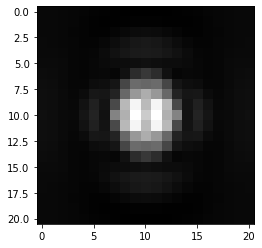

17 tensor(0.0365) tensor(0.0066) tensor(1.)


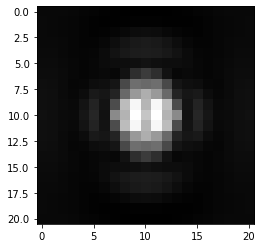

18 tensor(0.0359) tensor(0.0065) tensor(1.0000)


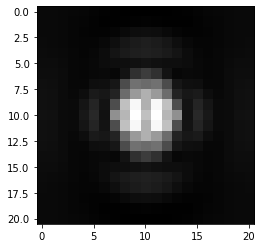

19 tensor(0.0354) tensor(0.0065) tensor(1.0000)


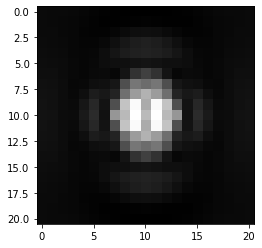

20 tensor(0.0348) tensor(0.0064) tensor(1.)


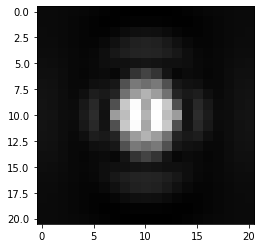

21 tensor(0.0343) tensor(0.0064) tensor(1.0000)


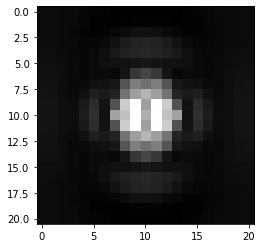

22 tensor(0.0337) tensor(0.0064) tensor(1.)


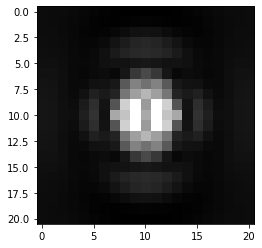

23 tensor(0.0334) tensor(0.0064) tensor(1.0000)


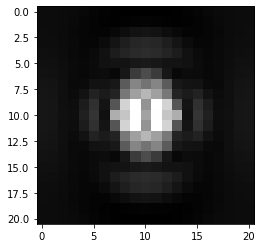

24 tensor(0.0331) tensor(0.0063) tensor(1.0000)


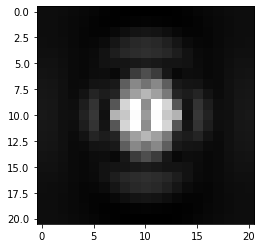

25 tensor(0.0328) tensor(0.0063) tensor(1.0000)


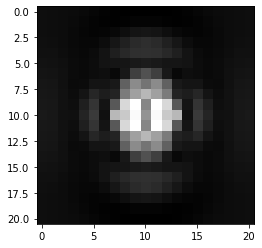

26 tensor(0.0325) tensor(0.0063) tensor(1.0000)


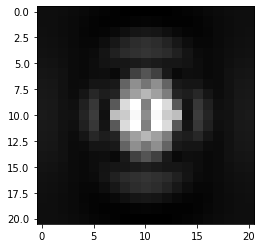

27 tensor(0.0322) tensor(0.0063) tensor(1.0000)


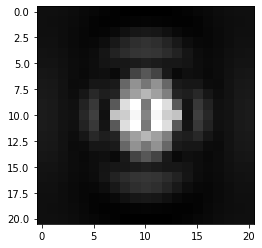

28 tensor(0.0319) tensor(0.0063) tensor(1.0000)


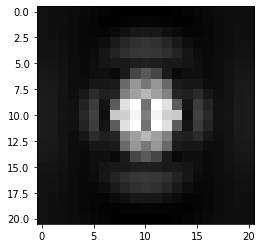

29 tensor(0.0316) tensor(0.0063) tensor(1.0000)


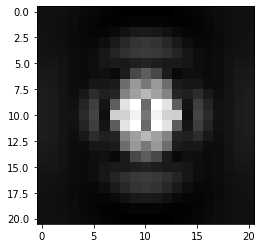

30 tensor(0.0313) tensor(0.0063) tensor(1.)


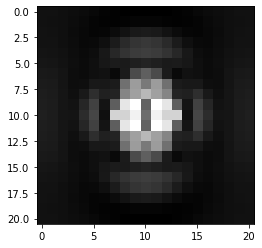

31 tensor(0.0310) tensor(0.0063) tensor(1.0000)


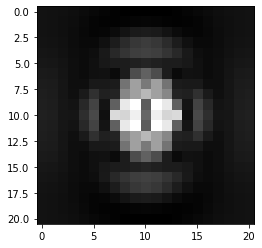

32 tensor(0.0307) tensor(0.0063) tensor(1.0000)


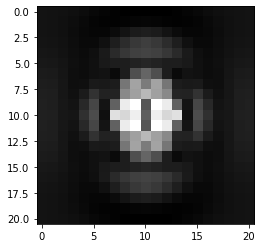

33 tensor(0.0304) tensor(0.0063) tensor(1.0000)


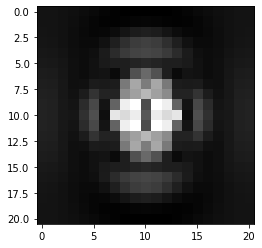

34 tensor(0.0301) tensor(0.0063) tensor(1.)


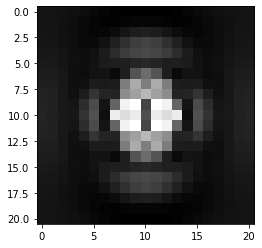

35 tensor(0.0298) tensor(0.0063) tensor(1.0000)


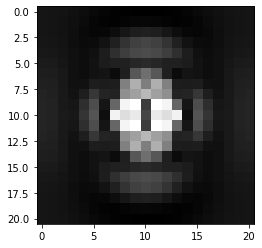

36 tensor(0.0295) tensor(0.0063) tensor(1.)


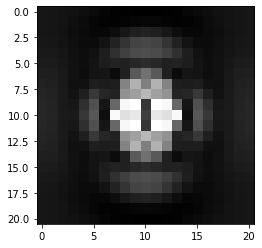

37 tensor(0.0292) tensor(0.0063) tensor(1.0000)


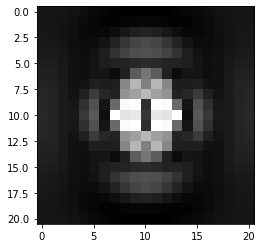

38 tensor(0.0296) tensor(0.0063) tensor(1.)


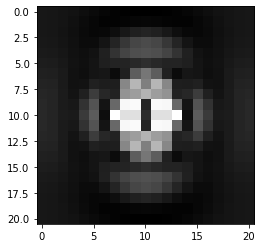

39 tensor(0.0301) tensor(0.0063) tensor(1.0000)


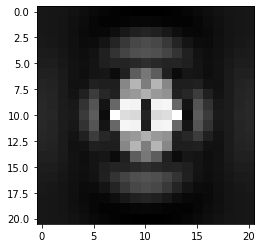

In [62]:
reduced = torch.stack(results_list[4]['krs'])
corrector_recons = get_recon(reduced)

# plt.figure(figsize=(6.4*num_iter, 4.8))
# for j in range(0, num_iter):
#     plt.subplot(1, num_iter+1, j+1)
#     plt.imshow(corrector_recons[j].numpy().reshape(21, 21), cmap="gray")
#     print(corrector_recons[j].max(), corrector_recons[j].std(), corrector_recons[j].sum())
# plt.show()

for j in range(0, num_iter):
    print(j, corrector_recons[j].max(), corrector_recons[j].std(), corrector_recons[j].sum())
    plt.imshow(corrector_recons[j].numpy().reshape(21, 21), cmap="gray")
    plt.show()


In [20]:
target_idx = {
#     '0.3' : 8,
#     '1.0' : 27,
    '1.5' : 198,
    '2.0' : 29,
    '2.5' : 1,
    '3.0' : 37,
#     '4.0' : 26
}

In [21]:
import copy

In [22]:
kerdic = copy.deepcopy(dataset._kernel_dict)

In [23]:
for k,v in target_idx.items():
    print(k,v)

1.5 198
2.0 29
2.5 1
3.0 37


In [17]:
KERNEL_SIZE=21
def set_dataset_kernels(self):
    self.kernels = self._kernel_dict['kernels']  # N x (21*21) 2d
    self.kernel_size = (KERNEL_SIZE, KERNEL_SIZE)  # (21, 21)
    self.k_reduced = self._kernel_dict['k_reduced']  # N x 21  2d
    self.stddevs = self._kernel_dict['stddevs']  # N standard deviations

In [18]:
_crops = "sample_imgs/IMG_6873.jpg"
crops = "sample_imgs/IMG_6873.jpg.png"

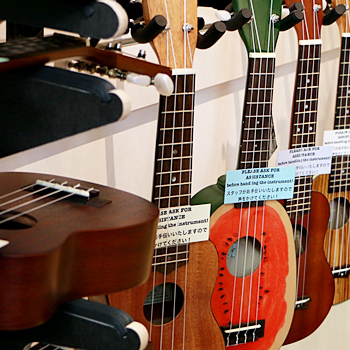

In [125]:
Image.open(_crops).crop((250,150,600,500))#.save(_crops+".png")

In [24]:
results = [[] for i in range(len(target_idx))]
for i, (k2, v2) in enumerate(target_idx.items()):
    for j, (k1, v1) in enumerate(target_idx.items()):
        lr_kerdic = dict()
        for k in kerdic:
            if isinstance(kerdic[k], list):
                lr_kerdic[k] = [kerdic[k][v1]]
            else:
                lr_kerdic[k] = kerdic[k]
        
        sr_kerdic = dict()
        for k in kerdic:
            if isinstance(kerdic[k], list) or isinstance(kerdic[k], np.ndarray):
                sr_kerdic[k] = [kerdic[k][v2]]
            else:
                sr_kerdic[k] = kerdic[k]
        
        dataset._kernel_dict = lr_kerdic
        set_dataset_kernels(dataset)
        dataset.random = np.random.RandomState(0)
        bd = image_to_bd(crops)
        print("lr:", bd['stddev'].item(), bd['k_reduced'])
        
        dataset._kernel_dict = sr_kerdic
        dataset.random = np.random.RandomState(0)
        set_dataset_kernels(dataset)
        bd_sr = image_to_bd(crops)
        print("sr:", bd_sr['stddev'].item())#, bd_sr['k_reduced'])
        bd['k_reduced'] = bd_sr['k_reduced']
        sr = sftmd_true(bd)
        padding = 10
        pad_value = 1
        sr[:, :padding, :] = pad_value
        sr[:, :, -padding:] = pad_value
        sr[:, -padding:, :] = pad_value
        sr[:, :, :padding] = pad_value
        results[i].append(sr)


lr: 1.6793278544989465 tensor([[-8.4646e-02,  1.3432e-02, -5.1146e-04,  9.2746e-03,  1.1258e-03,
         -7.8452e-03, -3.4500e-03, -3.0897e-03,  1.2846e-03, -9.8596e-04,
         -8.5302e-05, -1.5746e-04, -1.9575e-04, -3.6406e-04, -1.9501e-04,
         -1.4749e-04,  6.2881e-05,  1.4180e-04,  1.3472e-05, -3.7966e-05,
          1.4095e-05]], device='cuda:0')
sr: 1.6793278544989465
lr: 2.078718782282703 tensor([[-8.4646e-02,  1.3432e-02, -5.1146e-04,  9.2746e-03,  1.1258e-03,
         -7.8452e-03, -3.4500e-03, -3.0897e-03,  1.2846e-03, -9.8596e-04,
         -8.5302e-05, -1.5746e-04, -1.9575e-04, -3.6406e-04, -1.9501e-04,
         -1.4749e-04,  6.2881e-05,  1.4180e-04,  1.3472e-05, -3.7966e-05,
          1.4095e-05]], device='cuda:0')
sr: 1.6793278544989465
lr: 2.569948153857918 tensor([[-8.4646e-02,  1.3432e-02, -5.1146e-04,  9.2746e-03,  1.1258e-03,
         -7.8452e-03, -3.4500e-03, -3.0897e-03,  1.2846e-03, -9.8596e-04,
         -8.5302e-05, -1.5746e-04, -1.9575e-04, -3.6406e-04, -1.9

In [25]:
l = [] 
for i in range(len(target_idx)):
    l.append(    torch.cat(results[i], dim=-1) )
ls = torch.cat(l, dim=-2)

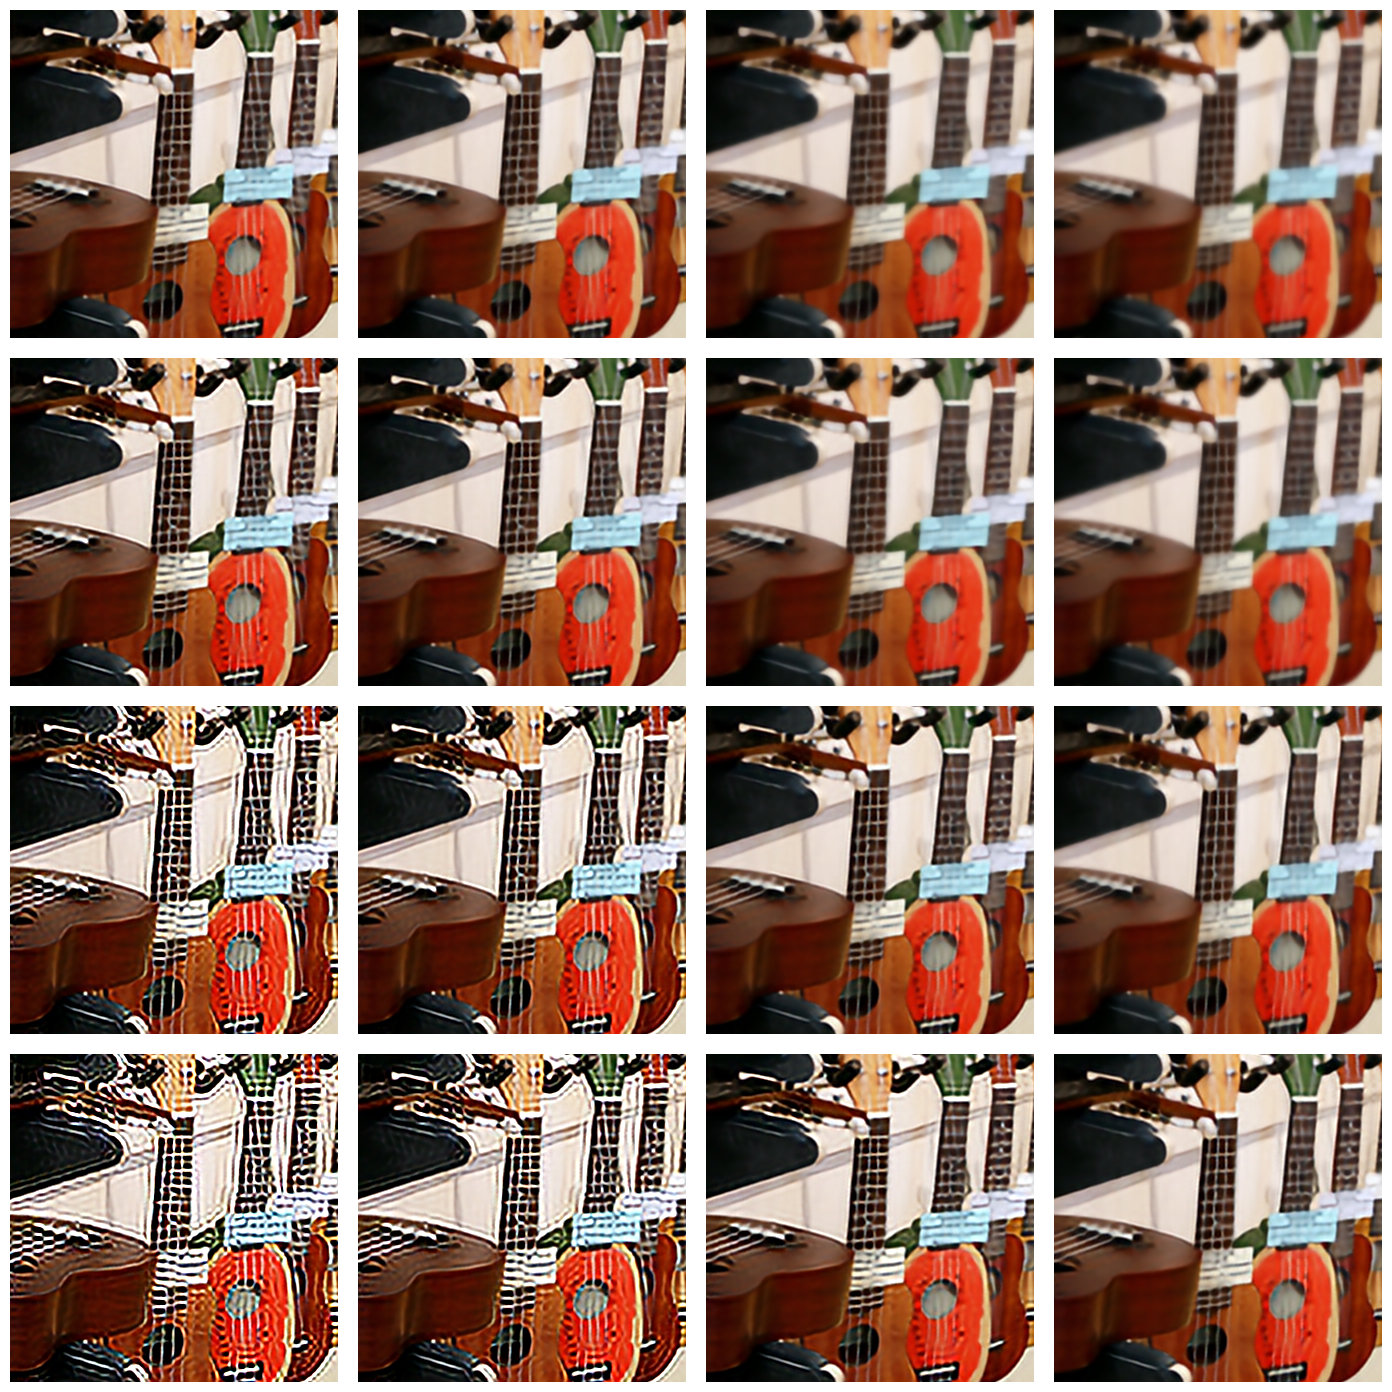

In [28]:
Image.fromarray(tensor2img(ls))

In [9]:
import pandas as pd

In [ ]:
aniso = 